In [16]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


from pclib.utils.customdataset import PreloadedDataset
%matplotlib inline

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

class Rescale(object):
    def __call__(self, img):
        return img / img.abs().max()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    # Rescale(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    # Rescale(),
    # InvTanhTransform(),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.CIFAR10('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# shorten dataset
# length = 10
# dataset = torch.utils.data.Subset(dataset, range(length))
# train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 3072
NUM_CLASSES = 10

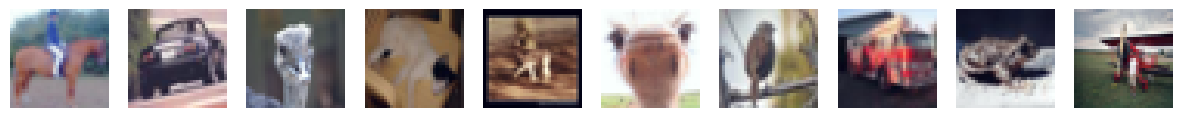

Max value:  tensor(2.1309, device='cuda:0')
Min value:  tensor(-1.9895, device='cuda:0')
Mean value:  tensor(0.0004, device='cuda:0')


In [13]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    # from standard gaussion to 0-1
    img = img / img.abs().max() / 2 + 0.5
    ax.imshow(img.squeeze().cpu().permute(1, 2, 0))
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())
print('Mean value: ', train_dataset.transformed_images.mean())

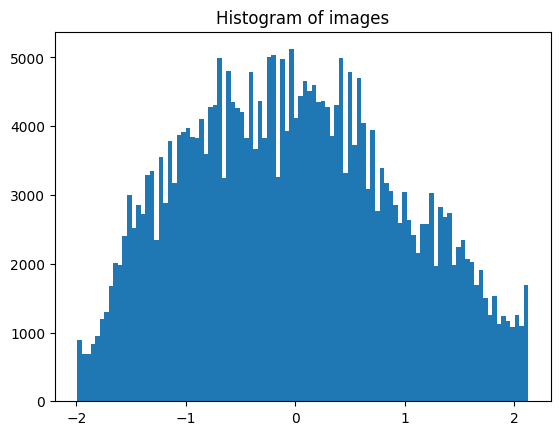

In [14]:
# plot histogram of images
plt.hist(train_dataset.transformed_images[:100].flatten().cpu(), bins=100)
plt.title('Histogram of images')
plt.show()


In [15]:
def train(
        model,
        train_dataset,
        val_dataset,
        optimiser,
        log_dir,
        batch_size=1000,
        num_epochs=100,
):
    writer = SummaryWriter(log_dir=log_dir)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    augment = transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))                          

    for epoch in range(num_epochs):

        loop = tqdm(train_loader, leave=False)
        if epoch > 0:
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(
                train_loss=train_loss,
                val_loss=val_loss,
                val_acc=val_acc,
            )
        train_loss = torch.tensor(0.0, device=device)

        for i, (imgs, labels) in enumerate(loop):
            imgs = augment(imgs)
            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)
            with torch.no_grad():
                train_loss += loss.detach()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        train_loss = (train_loss / len(train_loader)).item()
        
        # Validation
        correct = 0
        val_loss = torch.tensor(0.0, device=device)
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                loss = F.cross_entropy(outputs, labels) 
                val_loss += loss.detach()
                correct += (predicted == labels).sum()
        val_acc = correct.item() / len(val_dataset)
        val_loss = val_loss.item() / len(val_loader)

        model.inc_epochs()
        writer.add_scalar('Loss/train', train_loss, model.epochs_trained)
        writer.add_scalar('Loss/val', val_loss, model.epochs_trained)
        writer.add_scalar('Accuracy/val', val_acc, model.epochs_trained)

In [20]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.epochs_trained = 0
        self.layers = nn.Sequential(
            nn.Linear(3072, 1000),
            nn.ReLU(),
            nn.Linear(1000, 250),
            # nn.ReLU(),
            nn.Linear(250, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
        )
    
    def inc_epochs(self):
        self.epochs_trained += 1
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

model = Model().to(device)
model_name = "FFWD-1000R-250-1000R-10-BatchAug"
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0003)
print('Num params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
x = summary(model, (3, 32, 32))

Num params: 3584260
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 1000]                3,073,000
|    └─ReLU: 2-2                         [-1, 1000]                --
|    └─Linear: 2-3                       [-1, 250]                 250,250
|    └─Linear: 2-4                       [-1, 1000]                251,000
|    └─ReLU: 2-5                         [-1, 1000]                --
|    └─Linear: 2-6                       [-1, 10]                  10,010
Total params: 3,584,260
Trainable params: 3,584,260
Non-trainable params: 0
Total mult-adds (M): 7.16
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 13.67
Estimated Total Size (MB): 13.70


In [ ]:
import summary


In [8]:
log_dir = f'examples/cifar10/logs/{model_name}'
train(model, train_dataset, val_dataset, optimiser, log_dir, batch_size=1000, num_epochs=100)